COLOR TRANSFER

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
import sklearn.mixture    # for EM
import time
import numpy as np
import ot
import scipy.stats as sps
import scipy.linalg as spl

# Images

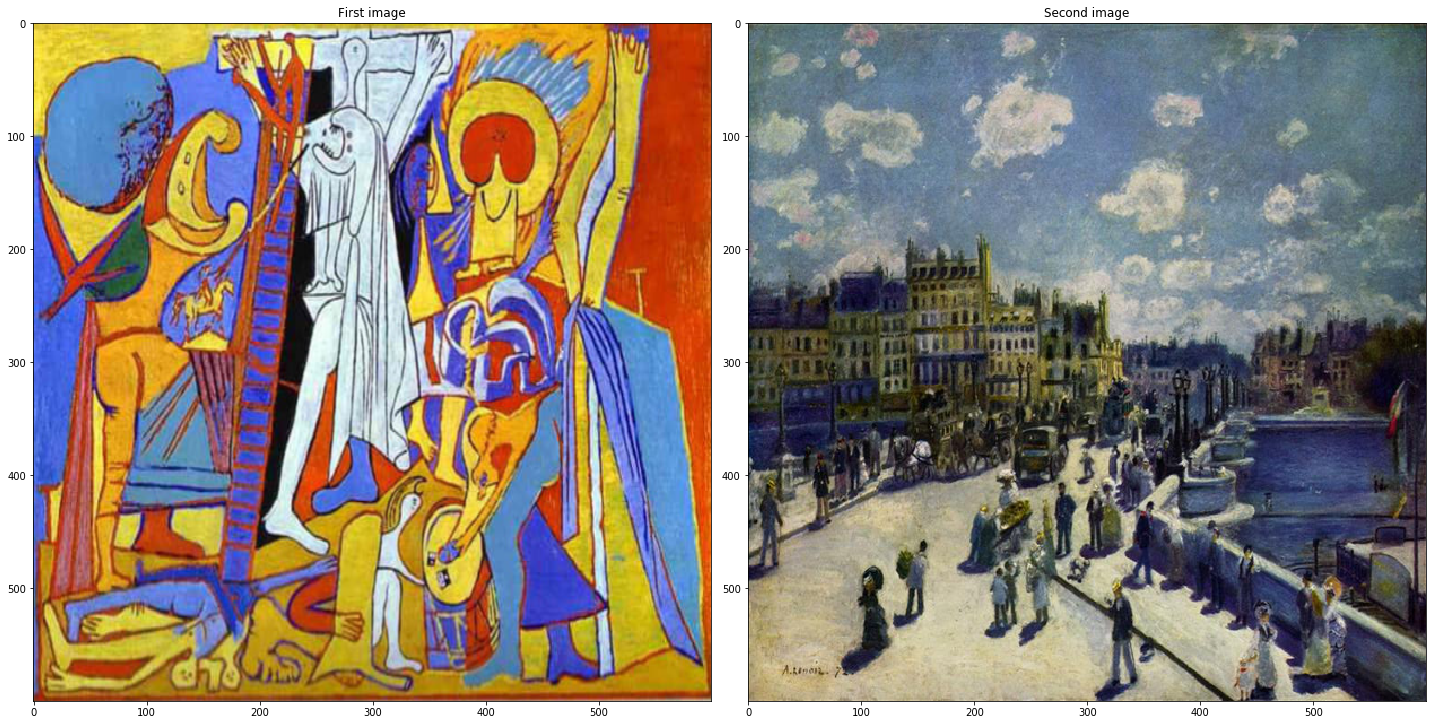

In [2]:
path = '../im/'
u = plt.imread(path+'Picasso.jpg')/255
v = plt.imread(path+'renoirPont.jpeg')/255
u = resize(u,(600,600))
v = resize(v,(600,600))
nru,ncu,nch = u.shape
nrv,ncv,nch = v.shape

# image display thanks to the function imshow of the pyplot library of matplotlib
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

#we display the images
axes[0].imshow(u)
axes[0].set_title('First image')
axes[1].imshow(v)
axes[1].set_title('Second image')
fig.tight_layout()

In [3]:
def hist(X,Y, colX,colY):
    fig  = plt.figure(2, figsize=(20, 10))
    axis = fig.add_subplot(1, 2, 1, projection="3d")
    axis.scatter(X[:, 0], X[:,1],X[:, 2], c=colX,s= 25*500 / len(X))
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
    axis = fig.add_subplot(1, 2, 2, projection="3d")
    axis.scatter(Y[:, 0], Y[:,1],Y[:, 2], c=colY, s = 25*500 / len(Y))
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

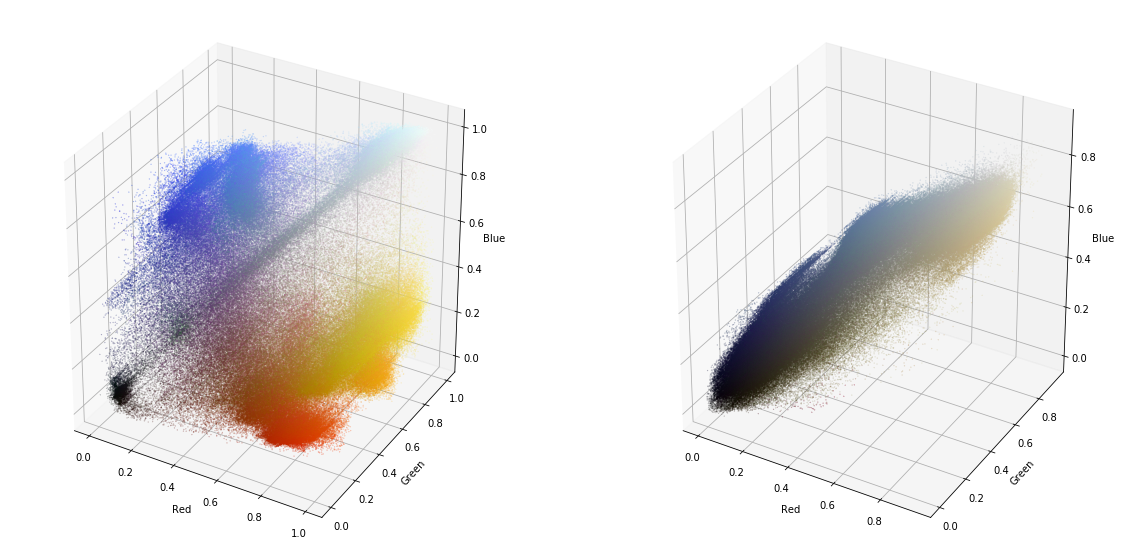

In [4]:
X = u.reshape((nru*ncu,3))
Y = v.reshape((nrv*ncv,3))
hist(X,Y,X,Y)

# Approximation by GMMs

In [5]:
def GMM_approx(u,v, k):

    X = u.reshape((nru*ncu,3))
    Y = v.reshape((nrv*ncv,3))
    ninit = 1
    K0,K1 = k,k # number of classes
    gmmX = sklearn.mixture.GaussianMixture(n_components=K0, covariance_type='full',n_init=ninit).fit(X) # spherical or full 
    pi0,mu0,S0 = gmmX.weights_, gmmX.means_, gmmX.covariances_ 
    ClassesX = gmmX.predict(X) 
    ProbaClassesX = gmmX.predict_proba(X) 

    gmmY = sklearn.mixture.GaussianMixture(n_components=K1, covariance_type='full',n_init=ninit).fit(Y)  # spherical or full 
    pi1,mu1,S1 = gmmY.weights_, gmmY.means_, gmmY.covariances_ 
    ClassesY = gmmY.predict(Y) 
    ProbaClassesY = gmmY.predict_proba(Y)
    
    return ClassesX, ClassesY, mu0, mu1, pi0, pi1, S0, S1, ProbaClassesX, ProbaClassesY

In [ ]:
ClassesX, ClassesY, mu0, mu1 = GMM_approx(u,v,8)
#c = mu0[ClassesX,:]
#hist(X,X,X,c)

In [ ]:
# For Latex
def hist_latex(u,ClassesX,mu):
    X = u.reshape((nru*ncu,3))
    c = mu[ClassesX,:]

    fig  = plt.figure(3, figsize=(18, 8))
    axis = fig.add_subplot(1, 3, 1)
    axis.imshow(u)  
    axis.axis("off")
    axis = fig.add_subplot(1, 3, 2, projection="3d")
    axis.scatter(X[:, 0], X[:,1],X[:, 2], c=X,s= 25*500 / len(X))
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
    axis = fig.add_subplot(1, 3, 3, projection="3d")
    axis.scatter(X[:, 0], X[:,1],X[:, 2], c=c, s = 25*500 / len(Y))
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

In [ ]:
hist_latex(u,ClassesX,mu0)

In [ ]:
hist_latex(v,ClassesY,mu1)

In [ ]:
# time scikit 
import time
def GMM_time(u,k=8):
    X = u.reshape((nru*ncu,3))
    ninit = 1
    K0,K1 = k,k # number of classes
    tic = time.time()
    gmmX = sklearn.mixture.GaussianMixture(n_components=K0, covariance_type='full',n_init=ninit).fit(X) # spherical or full 
    pi0,mu0,S0 = gmmX.weights_, gmmX.means_, gmmX.covariances_ 
    ClassesX = gmmX.predict(X) 
    ProbaClassesX = gmmX.predict_proba(X) 
    print(time.time()-tic)
    return
GMM_time(u)

# Colour Transfer

## GMMs

In [6]:
GMMl = []
kl = [3,8,15,50,100]
for k in kl:
    tic = time.time()
    GMMl.append(GMM_approx(u,v,k))
    toc = time.time()-tic
    print("Time {} classes: {}".format(k,toc))

Time 3 classes: 1.7237093448638916
Time 8 classes: 9.224888563156128
Time 15 classes: 22.697187423706055
Time 50 classes: 78.28292322158813
Time 100 classes: 163.80457210540771


## Helpers

In [7]:
def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

In [8]:
def GW2(pi0,pi1,mu0,mu1,S0,S1):
    # return the GW2 discrete map and the GW2 distance between two GMM
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return wstar,distGW2

In [9]:
def GaussianMap(m0,m1,Sigma0,Sigma1,x):
    # Compute the OT map (evaluated at x) between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1 
    # m0 and m1 must be 2D arrays of size 1xd
    # Sigma0 and Sigma1 must be 2D arrays of size dxd
    # x can be a matrix of size n x d,
    # each column of x is a vector to which the function is applied
    d = Sigma0.shape[0]
    m0 = m0.reshape(1,d)
    m1 = m1.reshape(1,d)
    Sigma0 = Sigma0.reshape(d,d)
    Sigma1 = Sigma1.reshape(d,d)
    Sigma  = np.linalg.inv(Sigma0)@spl.sqrtm(Sigma0@Sigma1)
    Tx        = m1+(x-m0)@Sigma
    return Tx

In [17]:
def Transport(ClassesX, ClassesY, mu0, mu1, pi0, pi1, S0, S1, ProbaClassesX, ProbaClassesY):
    K0 = pi0.shape[0]
    K1 = pi1.shape[0]
    
    # Compute the K0xK1 OT matrix between the members of the mixtures
    wstar,dist = GW2(pi0/np.sum(pi0),pi1/np.sum(pi1),mu0,mu1,S0,S1)

    # Compute all Tkl maps at all points of u 
    try:
        T = np.zeros((K0,K1,3,nru*ncu))
    except:
        try:
            T = np.zeros((K0,K1,3,nru*ncu), dtype=np.float32)
        except:
            T = np.zeros((K0,K1,3,nru*ncu), dtype=np.float16)
            
    for k in range(K0):
            for l in range(K1):
                T[k,l,:,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:],X).T   

    # Compute mean color transfer on all points
    Tmeanx = np.zeros((3,nru*ncu))
    for k in range(K0):
        for l in range(K1):
            Tmeanx += wstar[k,l]/pi0[k]*ProbaClassesX[:,k].T*T[k,l,:,:]

    # Compute random color transfer on all points (random sample with posterior distribution)
    #Trandx = np.zeros((3,nru*ncu))
    #tmp = np.zeros((K0*K1,nru*ncu))
    #for k in range(K0):
    #    for l in range(K1):
    #        tmp[k+K0*l,:]= wstar[k,l]/pi0[k]*ProbaClassesX[:,k]
    #for i in range(nru*ncu):
    #    m = np.random.choice(K0*K1,p=tmp[:,i])
    #    l = m//K0
    #    k = m - K0*l
    #    Trandx[:,i] = T[k,l,:,i]        


    # Compute best color transfer on all points (only best class for each point)
    #Tmaxx = np.zeros((3,nru*ncu))
    #normalisation = np.zeros((nru*ncu))
    #for k in range(K0):
    #    for l in range(K1):
    #        Tmaxx += wstar[k,l]*T[k,l,:,:]*(ClassesX==k).T
    #        normalisation +=wstar[k,l]*(ClassesX==k).T
    #Tmaxx = Tmaxx/normalisation


    # Display result as an image
    w=Tmeanx.T.reshape((nru,ncu,3))
    #wmax=Tmaxx.T.reshape((nru,ncu,3))
    #wrand=Trandx.T.reshape((nru,ncu,3))


    #we display the images
    #fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    #axes[0].imshow(np.clip(w,0,1))
    #axes[0].set_title('w')
    #axes[1].imshow(np.clip(wrand,0,1))
    #axes[1].set_title('wrand')
    #axes[2].imshow(np.clip(wmax,0,1))
    #axes[2].set_title('wmax')
    #fig.tight_layout()
    
    return w

## Transport Map

In [22]:
Tmeanl = []
for idx in range(len(GMMl)):
    tic = time.time()
    Tmeanl.append(Transport(*GMMl[idx]))
    print(kl[idx], time.time()-tic)
print(len(Tmeanl))

3 0.09886717796325684
8 0.6500058174133301
15 2.529054880142212
50 28.91657304763794
100 146.47164940834045
5


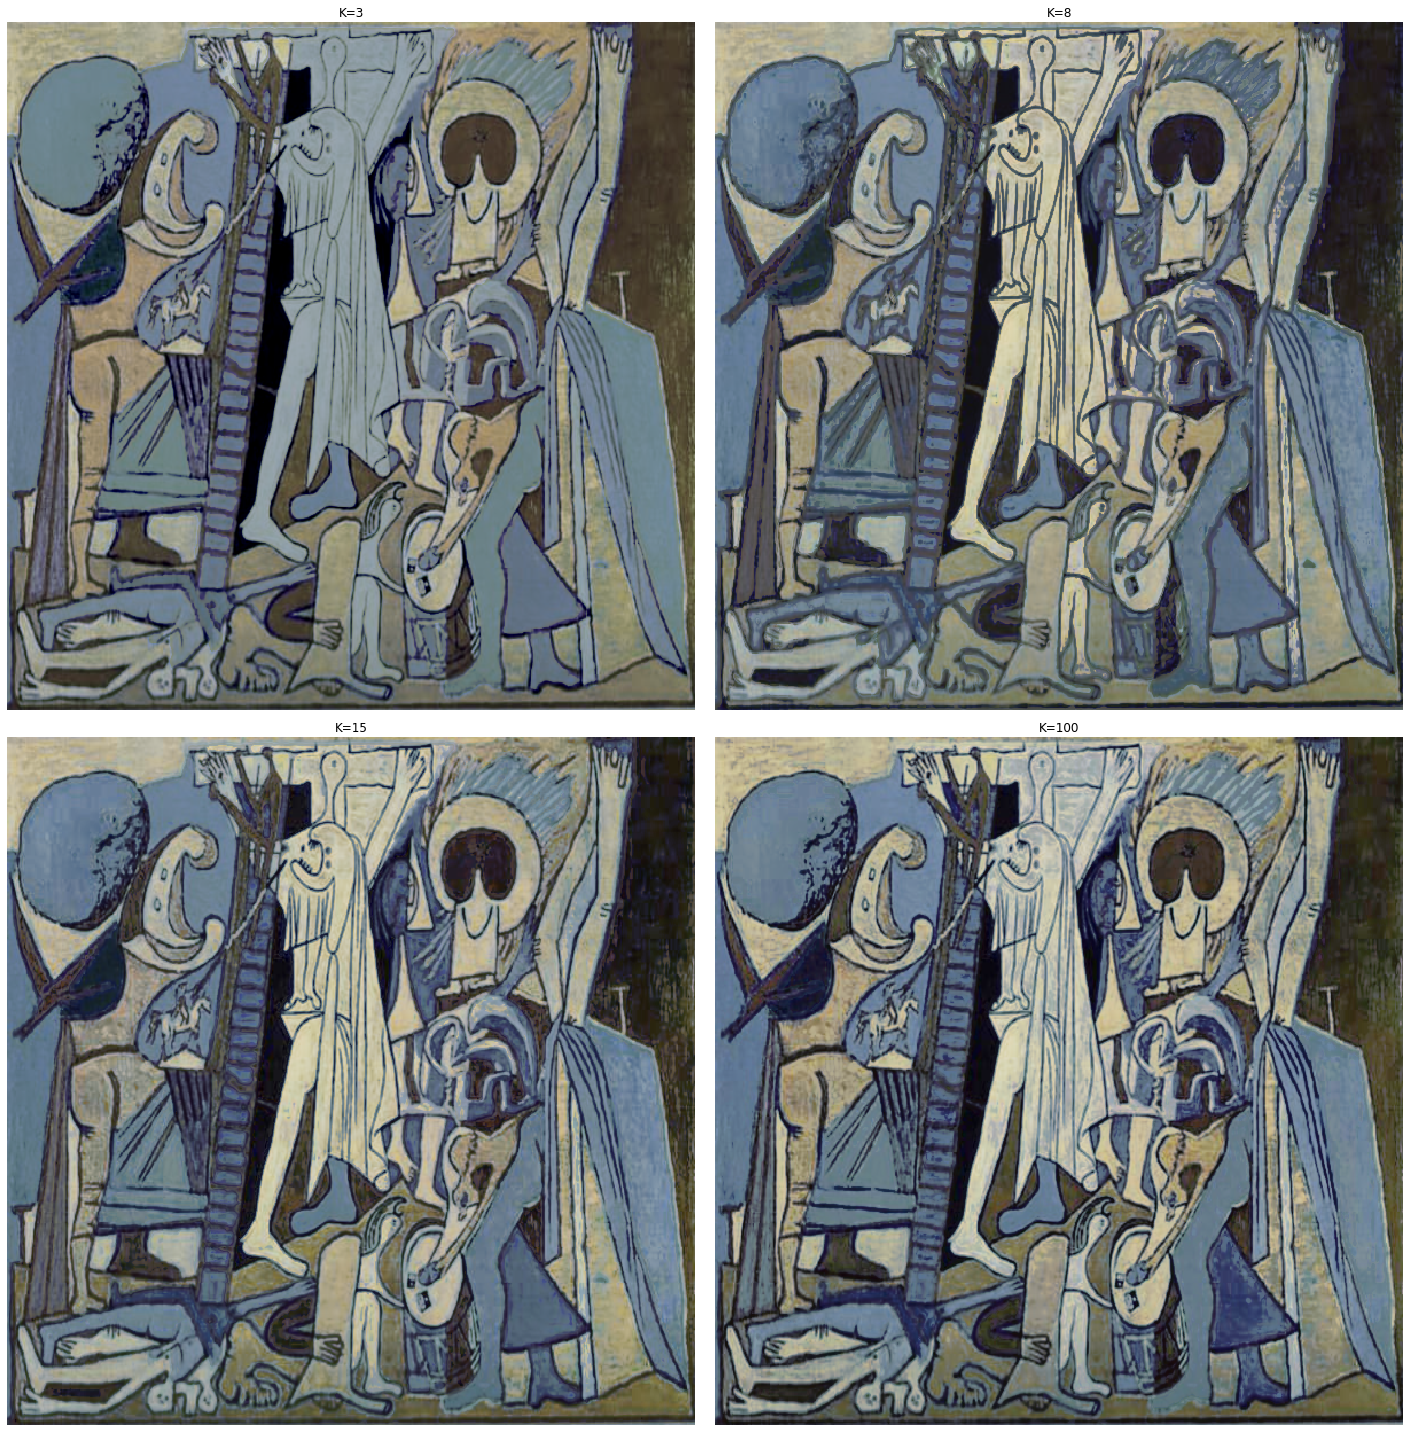

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axs = [[0,0],[0,1],[1,0],[1,1]]
for ki,(ax1,ax2) in zip([0,1,2,4],axs):
    w = Tmeanl[ki]
    axes[ax1,ax2].imshow(np.clip(w,0,1))
    axes[ax1,ax2].set_title('K={}'.format(kl[ki]))
    axes[ax1,ax2].axis("off")
fig.tight_layout()
plt.show()

In [ ]:
fig  = plt.figure(1, figsize=(10, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(Y[:, 0], Y[:,1],Y[:, 2], c=Y, s = 25*500 / len(Y))
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

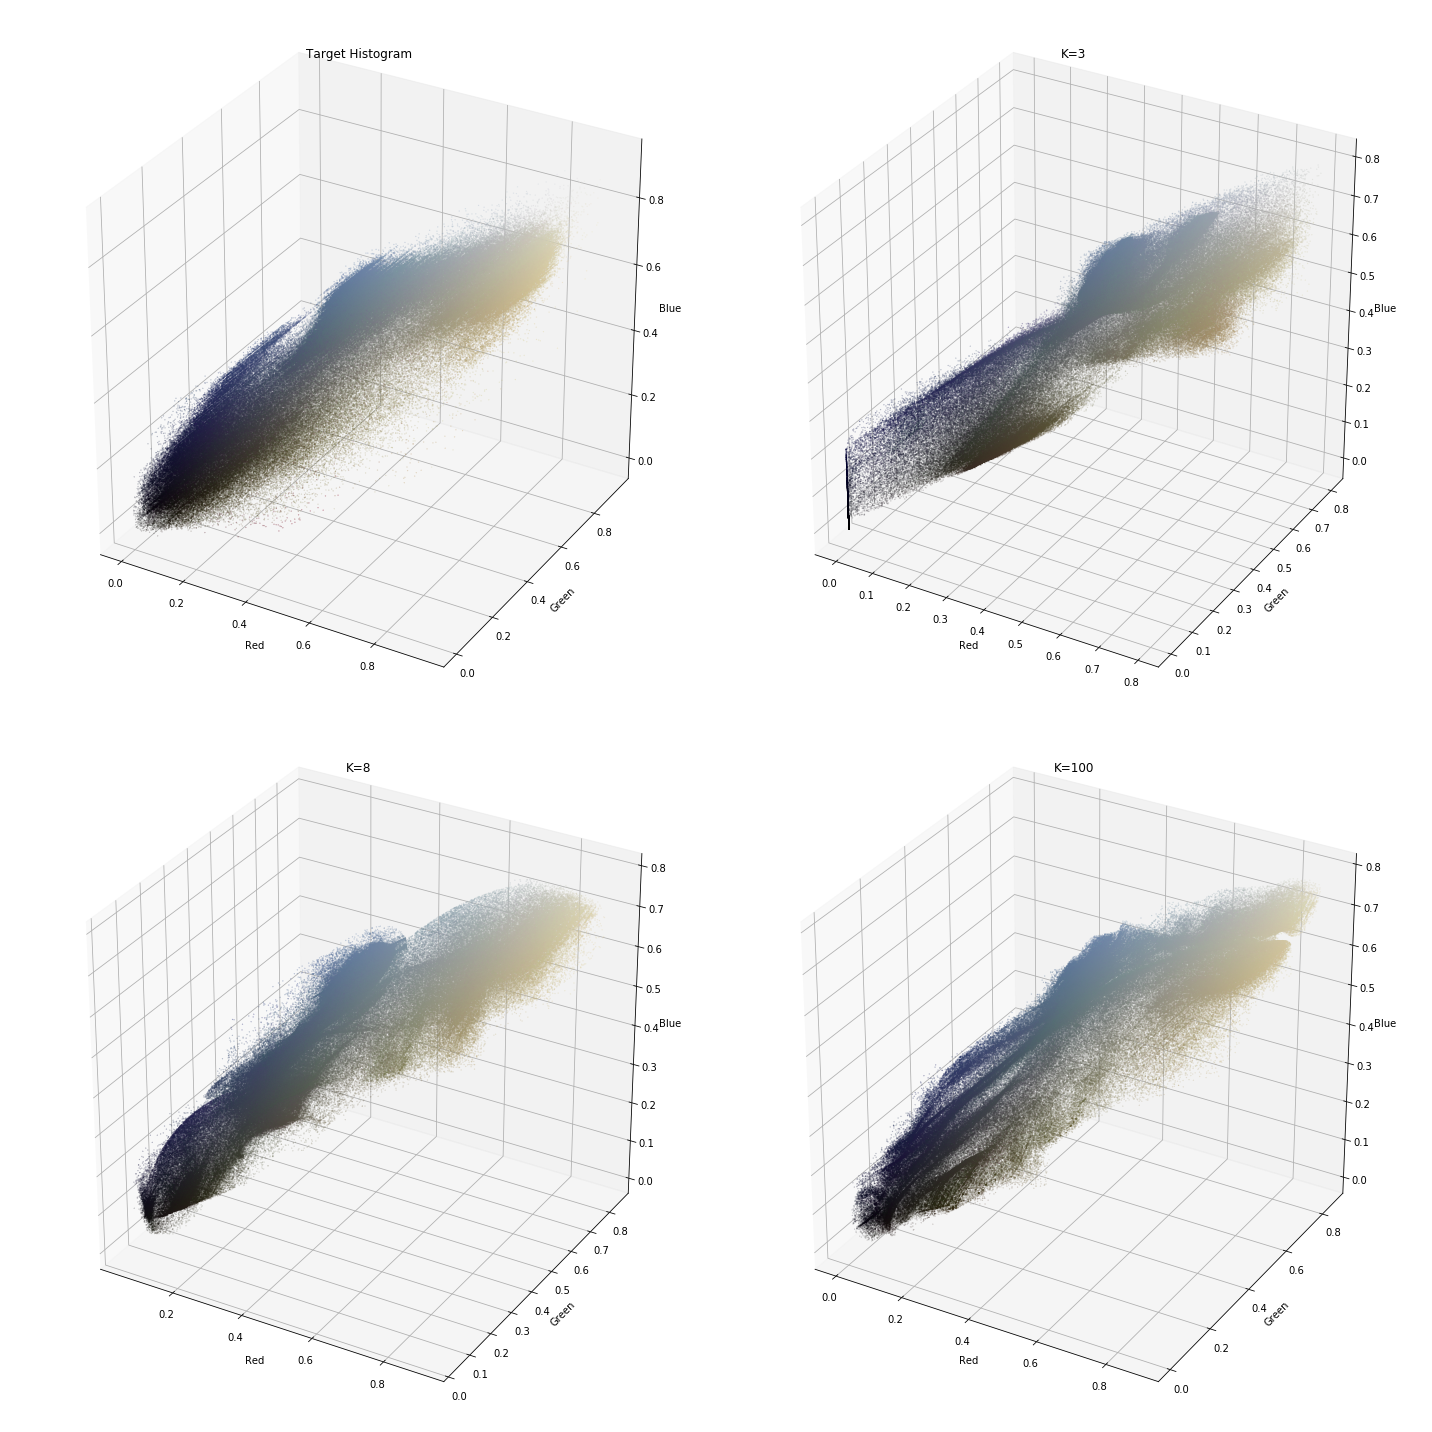

In [37]:
fig = plt.figure(4,figsize=(20, 20))
axis = fig.add_subplot(2, 2, 1, projection="3d")
axis.scatter(Y[:, 0], Y[:,1],Y[:, 2], c=Y, s = 25*500 / len(Y))
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis.set_title("Target Histogram")
w = Tmeanl[0]
W = w.reshape((w.shape[0]*w.shape[1],3))
W = np.clip(W,0,1)
axis = fig.add_subplot(2, 2, 2, projection="3d")
axis.scatter(W[:, 0], W[:,1],W[:, 2], c=W,s= 25*500 / len(W))
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis.set_title("K=3")
w = Tmeanl[1]
W = w.reshape((w.shape[0]*w.shape[1],3))
W = np.clip(W,0,1)
axis = fig.add_subplot(2, 2, 3, projection="3d")
axis.scatter(W[:, 0], W[:,1],W[:, 2], c=W,s= 25*500 / len(W))
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis.set_title("K=8")
w = Tmeanl[-1]
W = w.reshape((w.shape[0]*w.shape[1],3))
W = np.clip(W,0,1)
axis = fig.add_subplot(2, 2, 4, projection="3d")
axis.scatter(W[:, 0], W[:,1],W[:, 2], c=W,s= 25*500 / len(W))
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis.set_title("K=100")
fig.tight_layout()
plt.show()